In [1]:
import os
import scipy.misc
import numpy as np

from forward_model import DCGAN
from utils import pp, visualize, to_json, show_all_variables

import tensorflow as tf

from glob import glob
from ops import *
from utils import *

import matplotlib.pyplot as plt
%matplotlib inline

In [2]:
# flags
flags = tf.app.flags
flags.DEFINE_integer("epoch", 25, "Epoch to train [25]")
flags.DEFINE_float("learning_rate", 0.0002, "Learning rate of for adam [0.0002]")
flags.DEFINE_float("beta1", 0.5, "Momentum term of adam [0.5]")
flags.DEFINE_integer("train_size", np.inf, "The size of train images [np.inf]")
flags.DEFINE_integer("batch_size", 64, "The size of batch images [64]")
flags.DEFINE_integer("input_height", 108, "The size of image to use (will be center cropped). [108]")
flags.DEFINE_integer("input_width", None, "The size of image to use (will be center cropped). If None, same value as input_height [None]")
flags.DEFINE_integer("output_height", 64, "The size of the output images to produce [64]")
flags.DEFINE_integer("output_width", None, "The size of the output images to produce. If None, same value as output_height [None]")
flags.DEFINE_string("dataset", "celebA", "The name of dataset [celebA, mnist, lsun]")
flags.DEFINE_string("input_fname_pattern", "*.jpg", "Glob pattern of filename of input images [*]")
flags.DEFINE_string("checkpoint_dir", "checkpoint", "Directory name to save the checkpoints [checkpoint]")
flags.DEFINE_string("sample_dir", "samples", "Directory name to save the image samples [samples]")
flags.DEFINE_boolean("train", False, "True for training, False for testing [False]")
flags.DEFINE_boolean("crop", True, "True for training, False for testing [False]")
flags.DEFINE_boolean("visualize", False, "True for visualizing, False for nothing [False]")
FLAGS = flags.FLAGS

pp.pprint(flags.FLAGS.__flags)

if FLAGS.input_width is None:
    FLAGS.input_width = FLAGS.input_height
if FLAGS.output_width is None:
    FLAGS.output_width = FLAGS.output_height

if not os.path.exists(FLAGS.checkpoint_dir):
    os.makedirs(FLAGS.checkpoint_dir)
if not os.path.exists(FLAGS.sample_dir):
    os.makedirs(FLAGS.sample_dir)

#gpu_options = tf.GPUOptions(per_process_gpu_memory_fraction=0.333)
run_config = tf.ConfigProto()
run_config.gpu_options.allow_growth=True

{}


In [3]:
data = glob("./data/celebA/*.jpg")


sample_files = data[0:64] #change to 64 images
sample = [get_image(sample_file,
                    input_height=108,
                    input_width=None,
                    resize_height=64,
                    resize_width=64,
                    crop=True,
                    grayscale=False) for sample_file in sample_files]

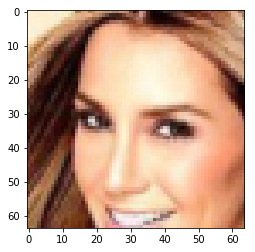

In [4]:
plt.imshow((sample[0] + 1.0)/2.0)
plt.show()

In [5]:
v = np.reshape(sample, (64, 64*64*3))
# number of features per image (pixels including all channels)
print('shape of v: {}'.format(v.shape))


n = v.shape[1]

shape of v: (64, 12288)


In [ ]:
# this is compressed sensing setting
m = 1000
A = np.random.randn(n, m).astype('float32')
A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
y = np.dot(v, A) 

# this is full image included setting
# m = n 
print('number of measurements = {}'.format(m))
# y = v

In [ ]:
# y_placeholder = tf.placeholder(tf.float32,[None,m])

# this loss is when we are doing compressed sensing
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 

# this loss is when we are taking image as measurement
# our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 

In [ ]:
y.shape

In [ ]:
#grad = tf.gradients(our_loss, dcgan.z)
#z_0 = np.random.uniform(-0.5, 0.5, size=(64 , 100))
count = 0

errs = []
    
    
with tf.Session() as sess:
    
    print(tf.global_variables())
    
    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)
    
    

    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")
    
    dcgan.z.initializer.run()
    
    y_placeholder = tf.placeholder(tf.float32,[None,m])
    
    # -----------------------------------
    # use this if we are not using A
    # our_loss = tf.reduce_mean( tf.reduce_sum( (tf.reshape(dcgan.G, [64, -1]) - y_placeholder)**2, 1)) 
    # use this if we are using A
    our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 
    # -----------------------------------
    
    z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  
    
#     show_all_variables()
    
    
    opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
    beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
    beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]
    
    sess.run(opt_initializers)
    sess.run(beta1_initializers)
    sess.run(beta2_initializers)

    
    for i in range(1000): # run until error stops decreasing or reaches threshhold, then print result at that point
        print('iteration {}'.format(count))
        a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
        count += 1
        print(closs)
        errs.append(closs)
        #z_0 = z_0 - rate*a[0]
    

In [ ]:
chosen_image = 19

fig = plt.figure()

ax1 = fig.add_subplot(121)
ax1.imshow((sample[chosen_image]+1.0)/2)

ax2 = fig.add_subplot(122)
ax2.imshow((b[chosen_image]+1.0)/2)
plt.show()

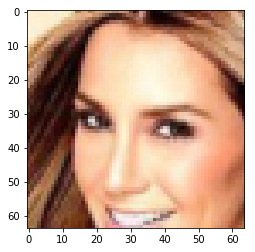

 [*] Reading checkpoints...
Instructions for updating:
Please use tf.global_variables instead.
z:0
generator/g_h0_lin/Matrix:0
generator/g_h0_lin/bias:0
generator/g_bn0/beta:0
generator/g_bn0/gamma:0
generator/g_bn0/moving_mean:0
generator/g_bn0/moving_variance:0
generator/g_h1/w:0
generator/g_h1/biases:0
generator/g_bn1/beta:0
generator/g_bn1/gamma:0
generator/g_bn1/moving_mean:0
generator/g_bn1/moving_variance:0
generator/g_h2/w:0
generator/g_h2/biases:0
generator/g_bn2/beta:0
generator/g_bn2/gamma:0
generator/g_bn2/moving_mean:0
generator/g_bn2/moving_variance:0
generator/g_h3/w:0
generator/g_h3/biases:0
generator/g_bn3/beta:0
generator/g_bn3/gamma:0
generator/g_bn3/moving_mean:0
generator/g_bn3/moving_variance:0
generator/g_h4/w:0
generator/g_h4/biases:0
discriminator/d_h0_conv/w:0
discriminator/d_h0_conv/biases:0
discriminator/d_h1_conv/w:0
discriminator/d_h1_conv/biases:0
discriminator/d_bn1/beta:0
discriminator/d_bn1/gamma:0
discriminator/d_bn1/moving_mean:0
discriminator/d_bn1/

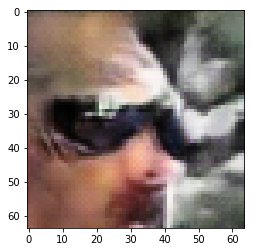

number of measurements = 100
iteration 0
1945.45
iteration 1
1619.3
iteration 2
1464.28
iteration 3
1319.82
iteration 4
1224.04
iteration 5
1143.45
iteration 6
1068.27
iteration 7
993.021
iteration 8
954.779
iteration 9
926.333


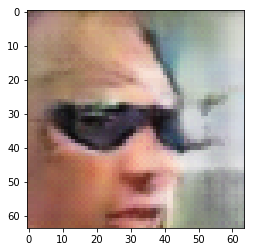

number of measurements = 200
iteration 0
1217.15
iteration 1
1172.72
iteration 2
1058.82
iteration 3
994.13
iteration 4
948.634
iteration 5
913.571
iteration 6
881.747
iteration 7
850.94
iteration 8
828.075
iteration 9
803.683


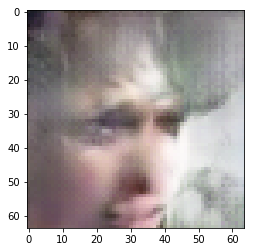

number of measurements = 500
iteration 0
973.42
iteration 1
981.297
iteration 2
901.273
iteration 3
865.749
iteration 4
849.505
iteration 5
816.223
iteration 6
789.748
iteration 7
771.16
iteration 8
751.098
iteration 9
738.677


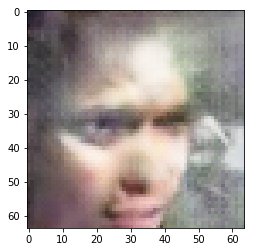

number of measurements = 1000
iteration 0
780.077
iteration 1
874.909
iteration 2
765.214
iteration 3
742.121
iteration 4
740.941
iteration 5
721.338
iteration 6
703.94
iteration 7
692.287
iteration 8
682.322
iteration 9
670.691


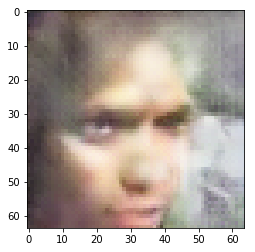

number of measurements = 2500
iteration 0
695.582
iteration 1
779.554
iteration 2
697.756
iteration 3
685.308
iteration 4
680.423
iteration 5
664.258
iteration 6
648.855
iteration 7
635.881
iteration 8
626.167
iteration 9
618.69


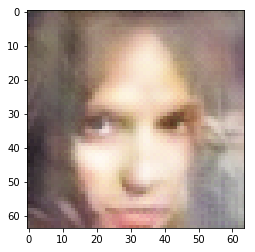

In [6]:
possible_ms = [50, 100, 200, 500, 1000, 2500, 5000, 7500, 10000]
num_iter = 1800
compressed_images = []

plt.imshow((sample[0] + 1.0)/2.0)
plt.show()


with tf.Session() as sess:

    #print(tf.global_variables())

    dcgan = DCGAN(
        sess,
        input_width=FLAGS.input_width,
        input_height=FLAGS.input_height,
        output_width=FLAGS.output_width,
        output_height=FLAGS.output_height,
        batch_size=FLAGS.batch_size,
        sample_num=FLAGS.batch_size,
        dataset_name=FLAGS.dataset,
        input_fname_pattern=FLAGS.input_fname_pattern,
        crop=FLAGS.crop,
        checkpoint_dir=FLAGS.checkpoint_dir,
        sample_dir=FLAGS.sample_dir)



    if not dcgan.load(FLAGS.checkpoint_dir)[0]:
        raise Exception("[!] Train a model first, then run test mode")

    dcgan.z.initializer.run()

    for m in possible_ms:
        A = np.random.randn(n, m).astype('float32')
        A = A / np.sqrt( np.sum( A**2, axis = 1 ) )[:,None]
        y = np.dot(v, A) 

        print('number of measurements = {}'.format(m))
        count = 0
        y_placeholder = tf.placeholder(tf.float32,[None,m])

        # -----------------------------------
        our_loss = tf.reduce_mean( tf.reduce_sum( (tf.matmul(tf.reshape(dcgan.G, [64, -1]) , A) - y_placeholder)**2, 1)) 
        # -----------------------------------

        z_optim = tf.train.AdamOptimizer(learning_rate=0.1).minimize(our_loss, var_list=dcgan.z)  

        opt_initializers   = [var.initializer for var in tf.global_variables() if 'Adam' in var.name]
        beta1_initializers = [var.initializer for var in tf.global_variables() if 'beta1_power' in var.name]
        beta2_initializers = [var.initializer for var in tf.global_variables() if 'beta2_power' in var.name]

        sess.run(opt_initializers)
        sess.run(beta1_initializers)
        sess.run(beta2_initializers)


        for i in range(num_iter): 
            print('iteration {}'.format(count))
            a, closs, b = sess.run([z_optim, our_loss, dcgan.G],feed_dict={y_placeholder: y})
            count += 1
            print(closs)
        plt.imshow((b[0] + 1.0)/2.0)
        compressed_images.append(b)
        plt.show()

    

[5559.47954431175, 4134.9930634899138, 3755.3277080587864, 3124.5437590556262, 2674.1877389947995, 2265.2140833117492]
[2256.5793252252543, 1369.7361796730454, 916.54346436568358, 724.65546743808522, 682.90064754868672, 655.32944160614306]


C:\Program Files\Anaconda3\lib\site-packages\matplotlib\pyplot.py:524: RuntimeWarning: More than 20 figures have been opened. Figures created through the pyplot interface (`matplotlib.pyplot.figure`) are retained until explicitly closed and may consume too much memory. (To control this warning, see the rcParam `figure.max_open_warning`).
  max_open_warning, RuntimeWarning)


[1562.3411746473689, 822.13532922108527, 787.00786192837461, 760.12395067298519, 634.73779502959815, 613.70804125979373]
[1758.1975090961287, 984.87535269283194, 855.41919253694891, 777.21197744175061, 782.58635548042105, 755.89499453460598]
[8518.5989059326748, 2607.7681642254288, 1985.3445491779653, 1497.0243703237425, 1249.1129705353178, 1048.3535674948171]
[1077.5370437910806, 961.79124497094745, 876.30016058671504, 732.57130329129495, 760.36891209512078, 600.74171284515762]
[1005.7757348934987, 580.88088410412274, 515.89371248944076, 474.38336191894535, 419.29704183337384, 397.86303858603793]
[1406.3984432436746, 1207.9882818836995, 1034.6434498569783, 869.8435843613845, 826.89057270046203, 766.32158810590113]
[1502.508508747851, 1172.3792238966612, 841.47173732371994, 728.90350063770722, 687.08610523197785, 658.27966665584745]
[1942.7555247844107, 1457.8633272839138, 1395.3181507272052, 1163.8558951469531, 1030.1666957382097, 841.77562020771791]


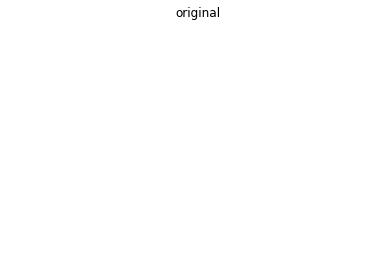

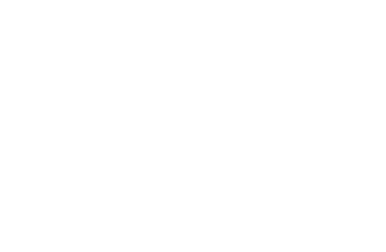

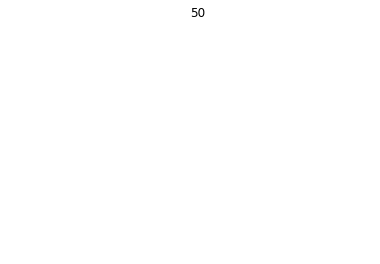

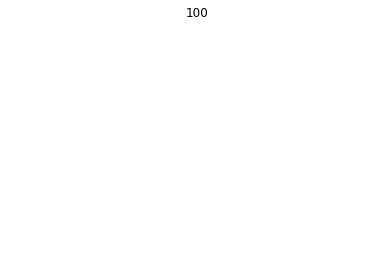

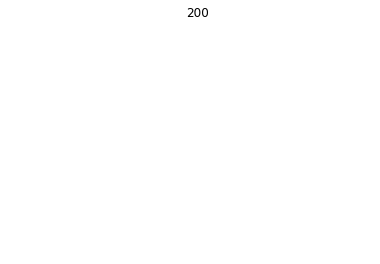

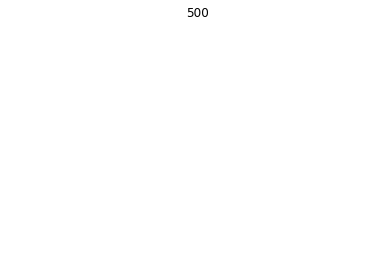

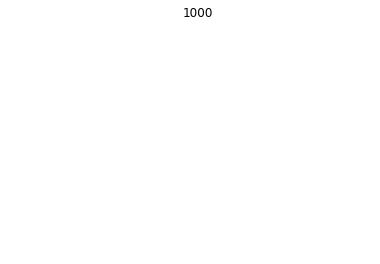

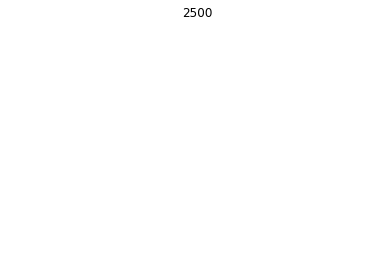

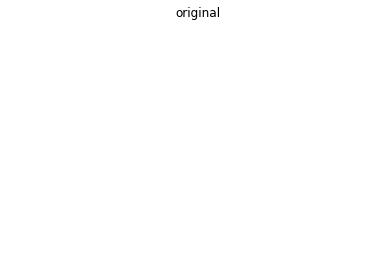

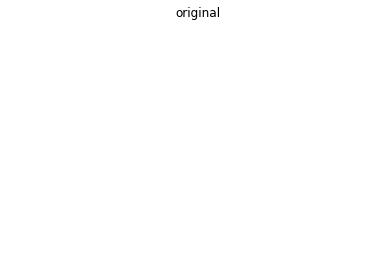

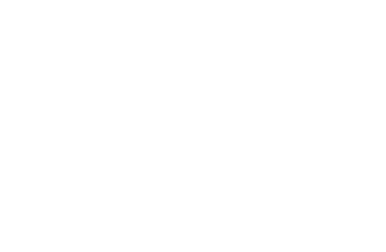

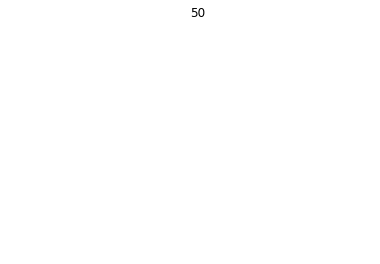

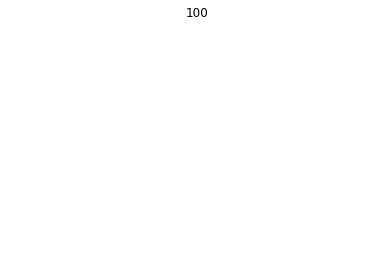

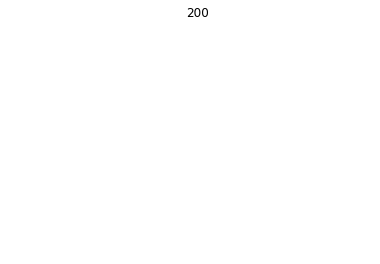

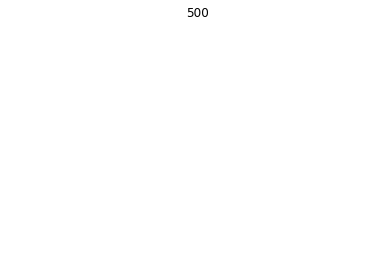

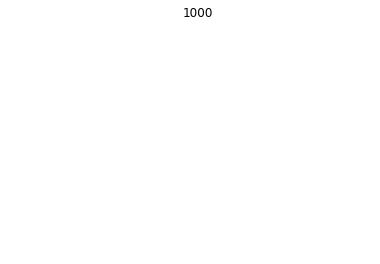

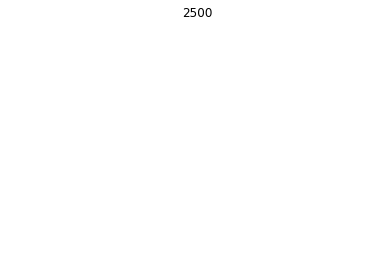

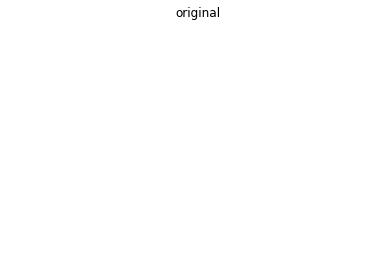

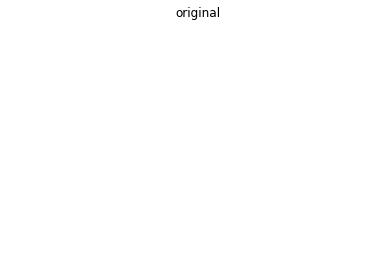

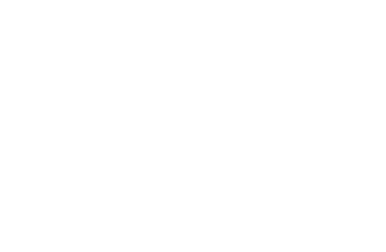

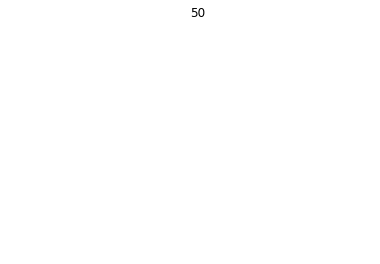

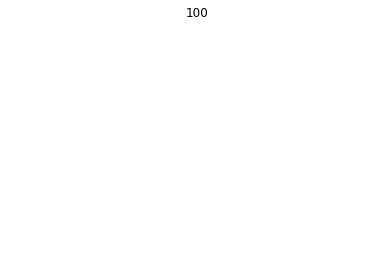

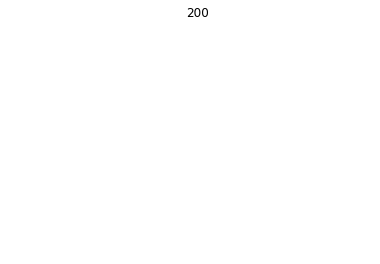

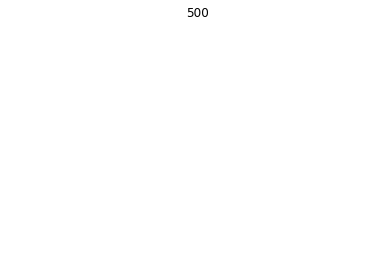

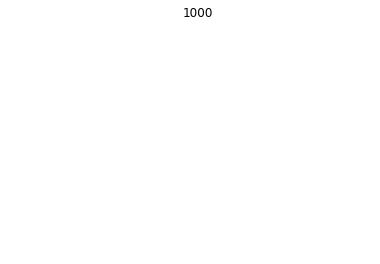

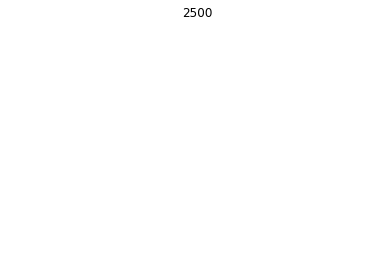

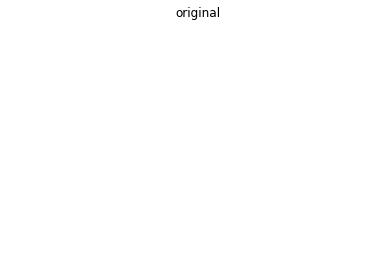

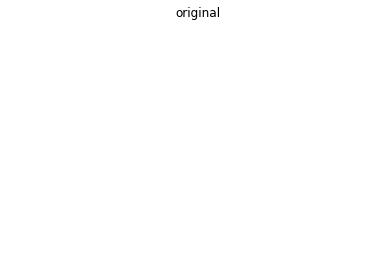

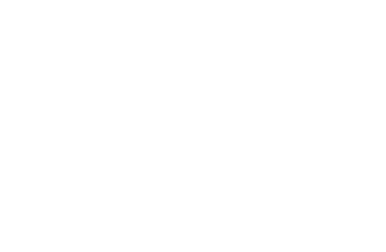

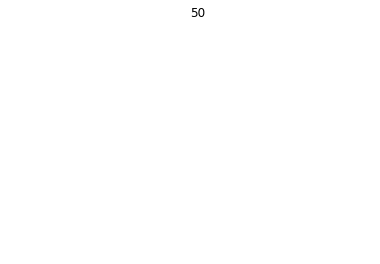

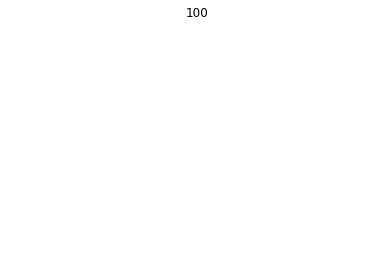

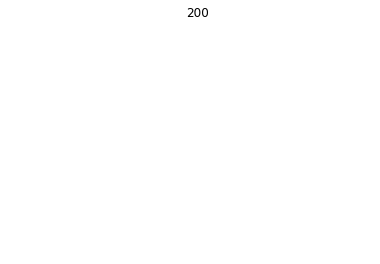

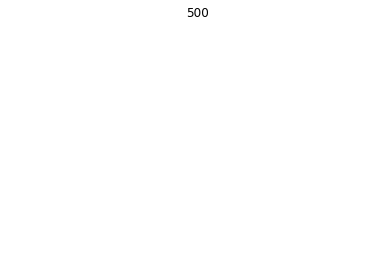

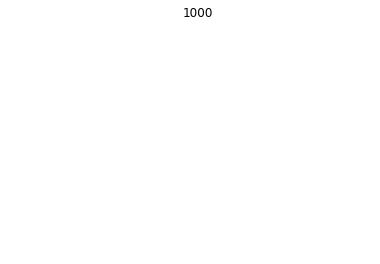

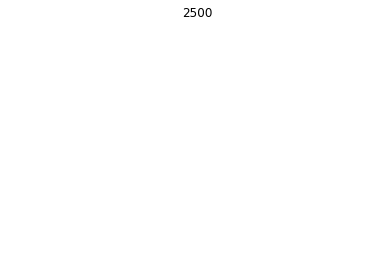

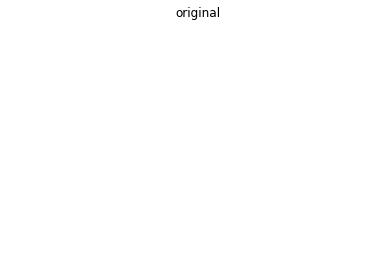

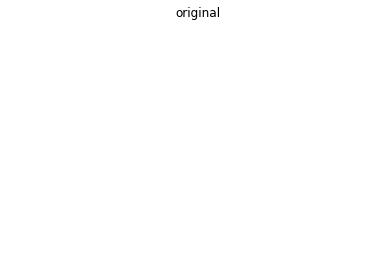

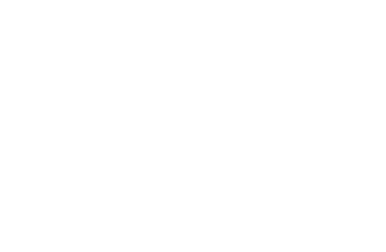

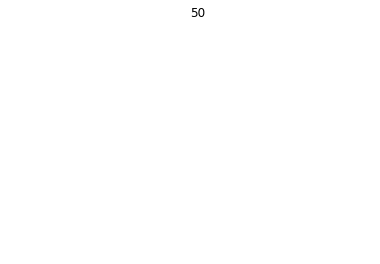

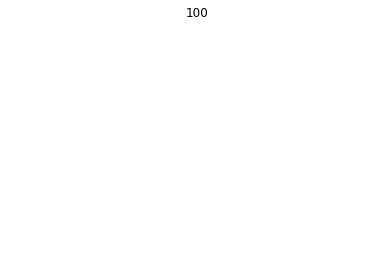

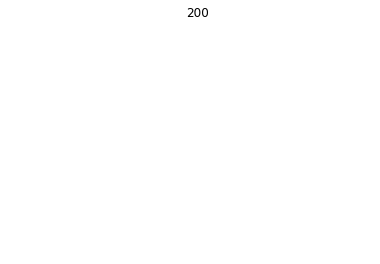

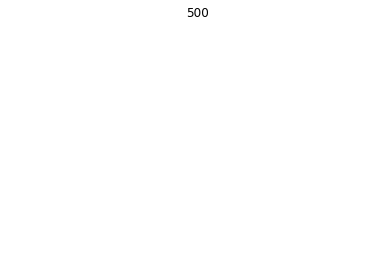

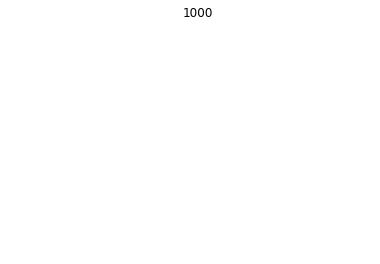

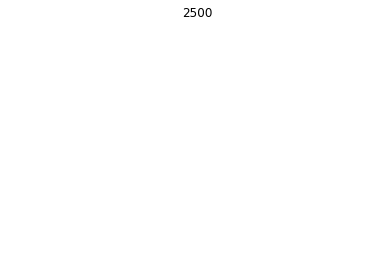

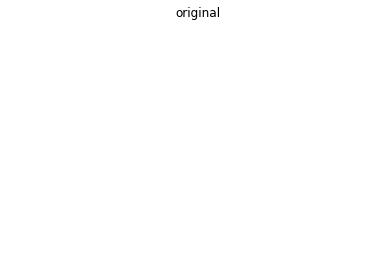

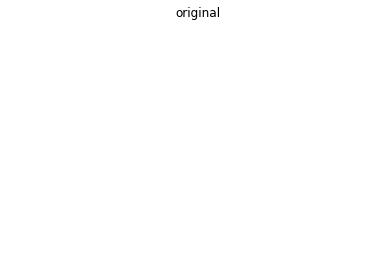

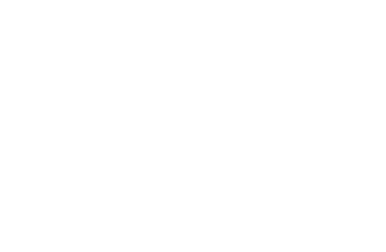

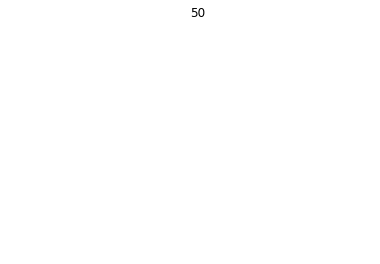

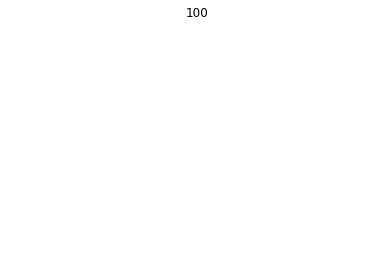

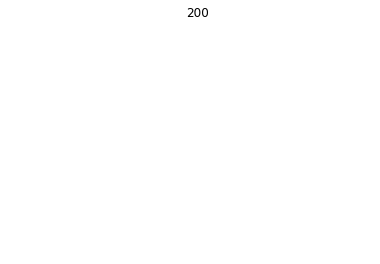

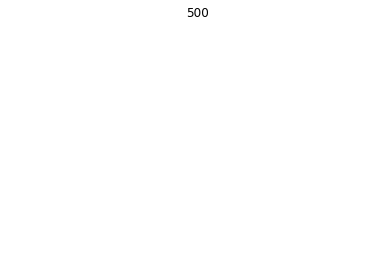

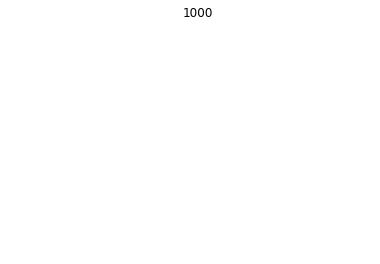

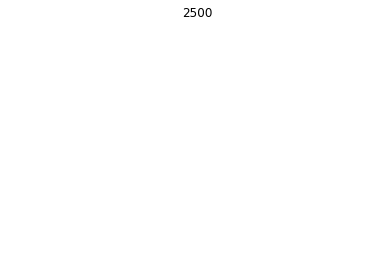

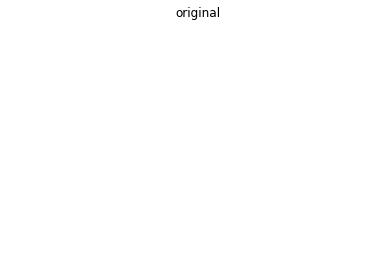

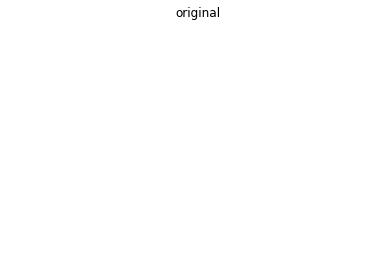

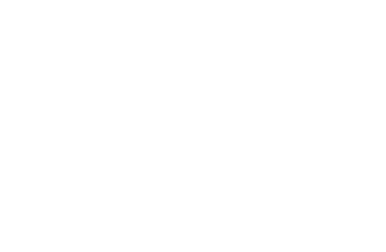

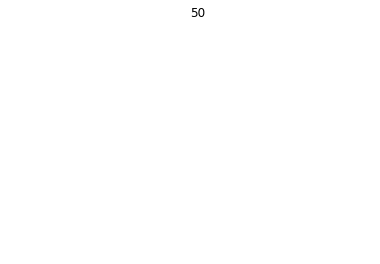

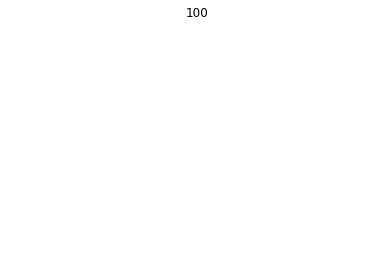

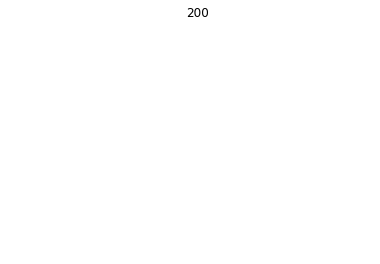

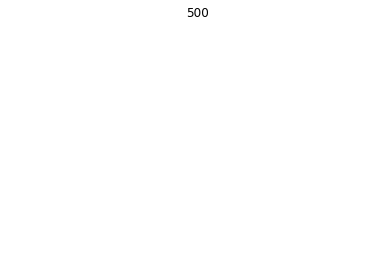

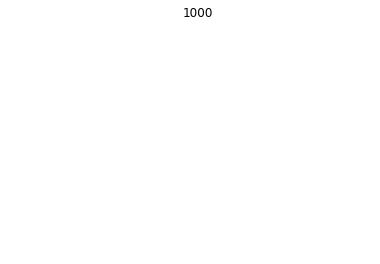

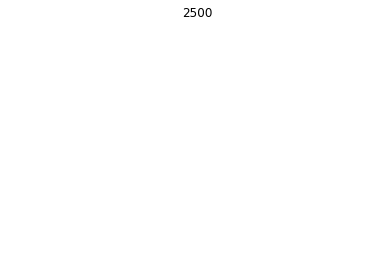

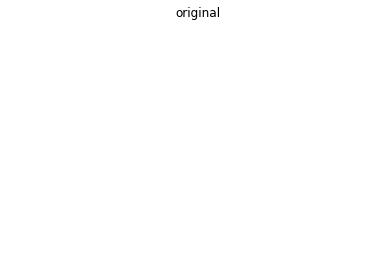

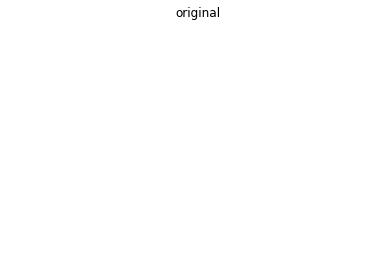

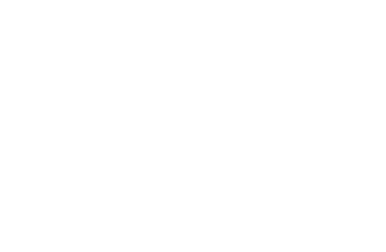

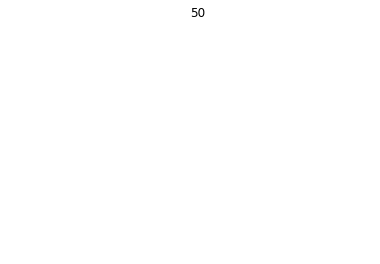

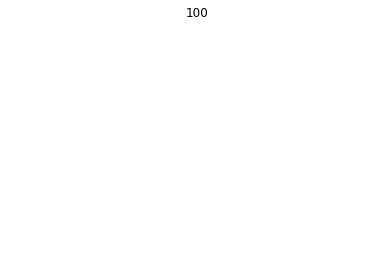

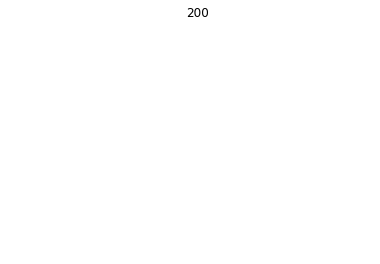

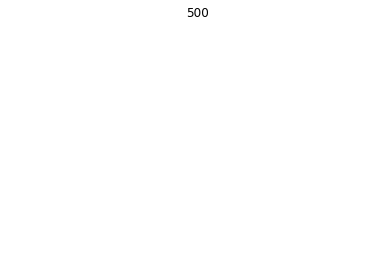

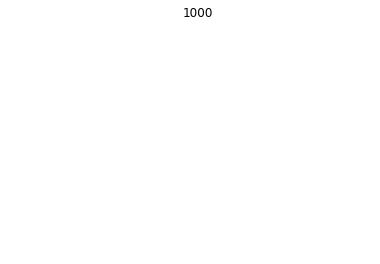

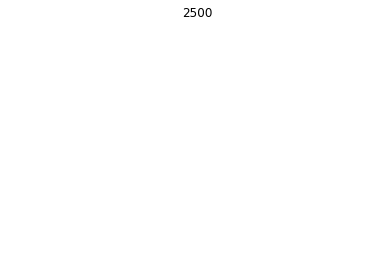

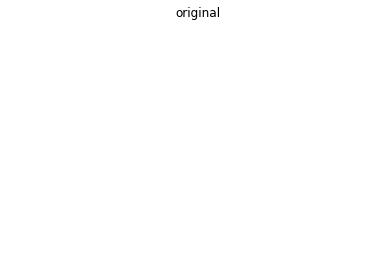

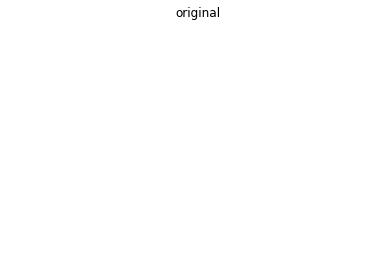

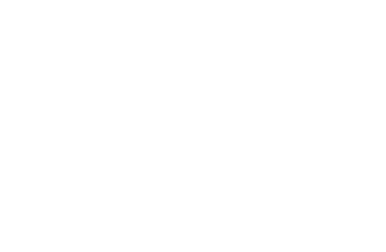

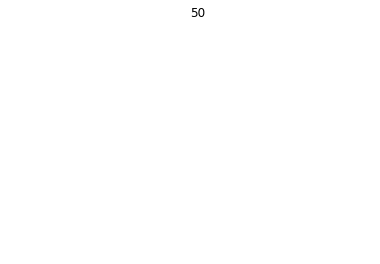

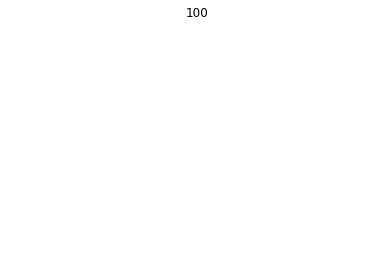

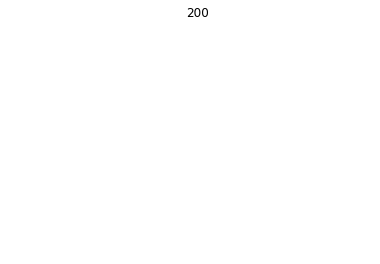

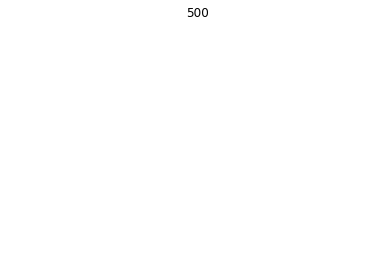

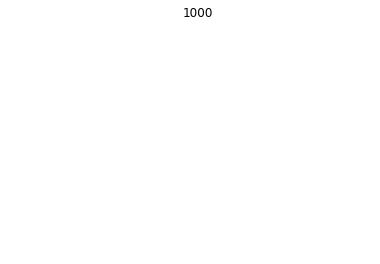

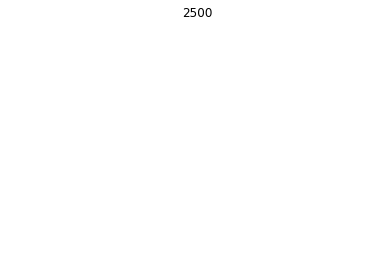

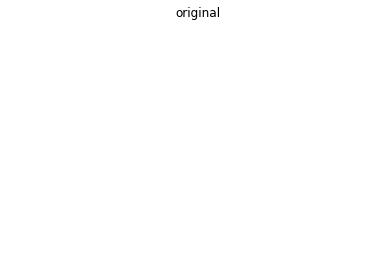

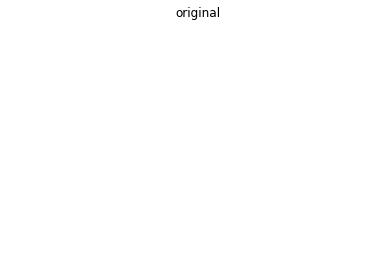

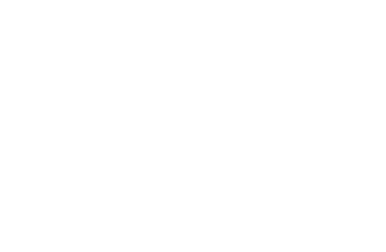

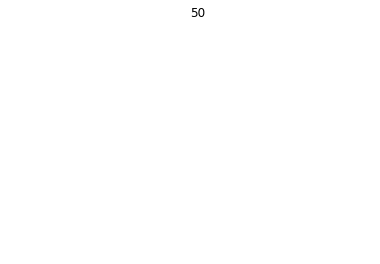

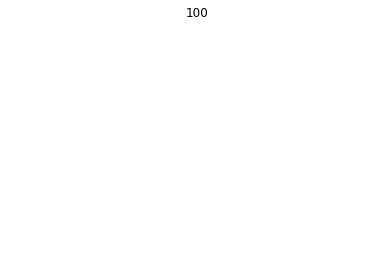

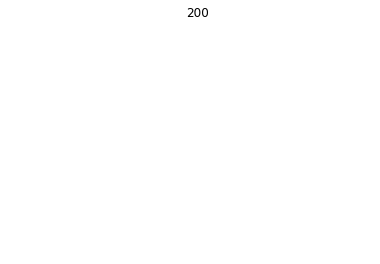

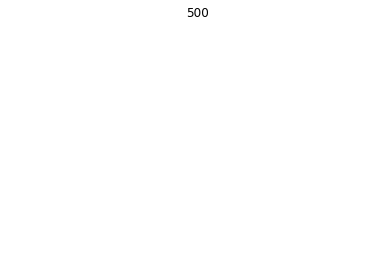

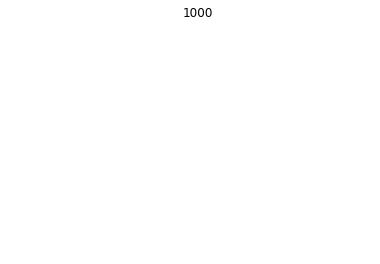

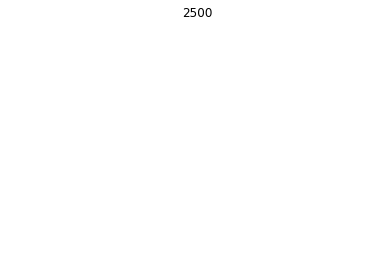

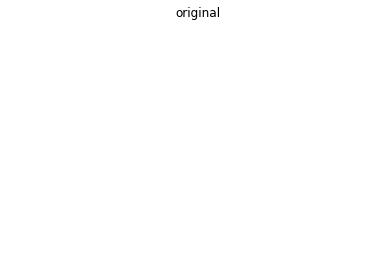

In [28]:
errors = []
for image_num in range(10):
    meas_err = []
    plt.figure()
    plt.title("original")
    plt.imshow((sample[image_num] + 1.0)/2.0) 
    plt.axis('off')

    fig = plt.figure()
    for i in range(len(compressed_images)):
        im = fig.add_subplot(2, len(compressed_images) / 2, i + 1)
        plt.imshow((compressed_images[i][image_num] + 1.0)/2.0)
        plt.axis('off')
        meas_err.append(np.sum((sample[image_num] - compressed_images[i][image_num])**2))
    #print(meas_err)
    errors.append(meas_err)

    for i in range(len(compressed_images)):
        plt.figure()
        plt.title(possible_ms[i])
        plt.imshow((compressed_images[i][image_num] + 1.0)/2.0)
        plt.axis('off')
        plt.figure()
    plt.title("original")
    plt.imshow((sample[image_num] + 1.0)/2.0) 
    plt.axis('off')

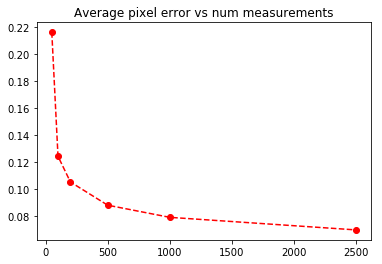

In [40]:
plt.plot(possible_ms, np.mean(errors, axis=0) / 12288.0, '--ro')
plt.title("Average training pixel error vs num measurements")
plt.show()